# Sektion 4 - Travelling Salesperson

## Functions

In [1]:
def get_unique_nodes(edge_list):
    """
    Assembles a list of all unique nodes appearing in a given graph.
    The start node is added by default; every other node is only included
    if it can be reached from another node. Isolated nodes will not be 
    added to the list, unless they happen to be the start node.
    """
    
    nr_nodes = 0
    unique_node_list = []
    unique_node_list.append(start_node)

    for edge in edge_list:
        if edge[1] not in unique_node_list:
            unique_node_list.append(edge[1])

    return unique_node_list


In [2]:
def construct_sliced_graph(edge_list, start_node):
    """
    Constructs a two-dimensional array from a list of edges. Each subarray represents 
    one time slice. The returned array contains the specified start node in the 
    first sub-array; based on this start node, every node that can be reached in 
    n steps is present in the nth subarray. Nodes that can be reached in a different 
    amount of steps are present in every fitting subarray.
    """
    
    sg = [] # sliced graph
    sg.append([start_node])
    node_counter = 1


    nr_unique_nodes = len(get_unique_nodes(edge_list))

    for k in range(nr_unique_nodes):
    
        if len(sg[k]) != 0:
            sg.append([])       # add a slice, then fill it
            for j in range(len(edge_list)):
                if edge_list[j][0] in sg[k] and edge_list[j][1] not in sg[k+1] and (edge_list[j][1] != start_node or k+1 == nr_unique_nodes):
                    sg[k+1].append(edge_list[j][1])
        else:
            break

    if start_node in sg[-1]:
        sg[-1] = [start_node] # eliminate all other nodes in the last time slice; the last node has to be the start node.
    else:
        return None 
        # TODO - error handling; if the start node is not in the last time slice, then the problem is not solvable.

    # the last node is always the destination node.
    # therefore we can eliminate all nodes in the next-to-last slice that do not lead to the destination node.
    # going back that way, we can eliminate nodes that won't lead to our destination.
    nr_slices_to_remove = 0

    for i in range(len(sg) - 1):
        nodes_to_remove = []
        index = len(sg) - 1 - i
        for j in range(len(sg[index - 1])):
            leads_to_next_slice = 0 # number of edges in the next slice that sg[index-1][j] is connected to
            for k in range(len(sg[index])):

                # for each node in the next slice, add 1 if sg[index-1][j] is connected to it, 0 if not
                leads_to_next_slice += next((1 for u, v in enumerate(edge_list) if v[0] == sg[index-1][j] and v[1] == sg[index][k]), 0) 

            # if leads_to_next_slice is zero, it means sg[index-1][j] is not connected to any node in the next slice; essentially a dead end. 
            # it is removed, and any node in the previous slice that only connected to it will thus also be a dead end, and will be removed. etc., etc.
            if leads_to_next_slice == 0:
                nodes_to_remove.append(sg[index-1][j])

        for node in nodes_to_remove:
            print(nodes_to_remove)
            sg[index-1].remove(node)

    #slices_to_remove = [] TODO - check if this section can be removed
    #for i in range(len(sg)):
    #    if len(sg[len(sg) - 1 - i]) == 1 and dest in sg[len(sg) - 1 - i]:
    #        slices_to_remove.append(len(sg) - 1 - i)
    #    else:
    #        break
    
    #if len(slices_to_remove) > 1:
    #    for i in slices_to_remove[:-1]:
    #        del sg[i]
    #        # print('deleted slice ' + str(i))

    return sg

In [3]:
def construct_numbered_sliced_graph(sg): 
    """
    Based on a two-dimensional array that constructed time slices from a graph,
    renumbers the contents by giving each element its index in the corresponding 
    flattened array.
    Example: with input [[0], [1, 3], [2, 3]], output would be [[0], [1, 2], [3, 4]].
    """
    
    numbered_sg = [] # numbered sliced graph
    node_counter = 0

    for m in range(len(sg)):
        numbered_sg.append([])
        for n in range(len(sg[m])):
            numbered_sg[m].append(node_counter)
            node_counter+=1
    
    return numbered_sg

In [4]:
def is_node_in_slice(node, slice_index):
    """Returns 1 if the given node is present in the given slice, 0 if not."""
    
    if node in test_sg[slice_index]:
        return 1
    else:
        return 0

In [5]:
def qubit_position(node, slice_index):
    """
    For a given node label, determines the respective qubit index for the node in the given slice.
    For a graph g = [[0], [1, 2], [1]], qubit_position(1,2) would return 3, since node 1 in slice 2 
    corresponds to the third qubit. Counting for slices as well as qubits begins at 0.
    """
    
    if node not in test_sg[slice_index]:
        return 0
    else:
        return test_nsg[slice_index][test_sg[slice_index].index(node)]

In [6]:
def construct_graph_matrix(edge_list):
    """
    Constructs a dataframe that contains all edges present in 
    the graph. The returned dataframe can contain several edges 
    per two nodes. The entry at matrix[0][1] contains an array 
    of all edges that go from node 0 to node 1.
    """
    
    node_labels = get_unique_nodes(edge_list)
    graph_matrix = pd.DataFrame([[[] for _ in range(len(node_labels))] for _ in range(len(node_labels))], node_labels, node_labels)
    
    for edge in edge_list:
        start = edge[0]
        end = edge[1]
        graph_matrix[start][end].append(edge)

    return graph_matrix

In [7]:
def construct_cost_matrix(edge_matrix):
    """
    Constructs a dataframe that contains the cost for the edge 
    between any given pair of nodes a and b. If there is no 
    outgoing edge from a to b, the cost will be equal to the
    fixed penalty value. If there is exactly one edge, its cost
    will be used. If there are several, the smallest cost is 
    used.
    """

    node_labels = edge_matrix.columns
    cost_matrix = pd.DataFrame([[[] for _ in range(len(node_labels))] for _ in range(len(node_labels))], node_labels, node_labels)

    for i in node_labels:
        for j in node_labels:
            entries = edge_matrix[i][j]
            if len(entries) == 0:
                cost_matrix[i][j] = (penalty_value)
            elif len(entries) == 1:
                cost_matrix[i][j] = (entries[0][2]) ### ebenfalls TODO. muss sich nach der struktur richten. ist aber eig keine priorität; es ist ok, das hier so zu hardcoden
            else:
                best_cost = penalty_value # penalty by default bigger than the biggest edge cost
                for entry in entries:
                    if entry[2] < best_cost:
                        best_cost = entry[2]
                cost_matrix[i][j] = best_cost
    return cost_matrix

In [8]:
def find_index(node, time_slice, sliced_graph, numbered_sg):
    """
    For a given node, time slice, and sliced graph, determines the qubit index 
    of the node. If the node is not present in the given slice in the graph, 
    returns -1.
    """
    
    #numbered_graph = construct_numbered_sliced_graph(sliced_graph)
    for i in range(len(sliced_graph[time_slice])):
        if sliced_graph[time_slice][i] == node:
            return numbered_sg[time_slice][i]
    else:
        return -1

In [9]:
def fix_nodes(start, destination, sliced_graph, numbered_sg, cost_func):
    """
    In the given cost function, fixes specific nodes according to already known 
    values for the qubits. The qubits representing the start and destination nodes 
    are fixed at 1; any other nodes in the last time slice are fixed at 0. 
    """
    
    start_node_index = 'X_' + str(find_index(start, 0, sliced_graph, numbered_sg))
    cost_func.linear_constraint(linear={start_node_index: 1}, sense='==', rhs=1, name='start_node')

    dest_node_index = 'X_' + str(find_index(destination, -1, sliced_graph, numbered_sg))
    cost_func.linear_constraint(linear={dest_node_index: 1}, sense='==', rhs=1, name='destination_node')

    #counter = 0
    #for i in sliced_graph[-1]:
    #    if i != destination:
    #        index = 'X_' + str(find_index(i, -1, sliced_graph))
    #        cost_func.linear_constraint(linear={index: 1}, sense='==', rhs=0, name=('last_slice_constraint_' + str(counter)))

    # only the start node is in the first slice. so no iteration over other nodes needed
    # same with last slice

    return

In [10]:
def get_node_info_from_index(node_index, sg, nsg):
    """ For a given qubit index, returns the corresponding time slice and the node label. """

    for time_slice in range(len(nsg)):
        if node_index in nsg[time_slice]:

            pos = nsg[time_slice].index(node_index)
            node_label = sg[time_slice][pos]

            return time_slice, node_label

In [11]:
def result_evaluation(result, sg, nsg, cost_matrix):
    """ For a given qubit string, returns an explanation of the nodes that are passed per time slice. """
    
    counter = 0
    previous_node = None
    total_cost = 0
    solution_not_valid = False

    for i in range(len(result)):
        if result[i] == '1':
            time_slice, node_label = get_node_info_from_index(i, sg, nsg)
            if time_slice != counter:
                solution_not_valid = True

            if counter == 0:
                previous_node = node_label
            else:
                cost = cost_matrix[previous_node][node_label]
                total_cost += cost
                print(('\t\t\t\tcost: {}').format(cost))
                previous_node = node_label


            print(('node {} at time slice {}').format(node_label, time_slice))

            counter += 1

            
    print(('\ntotal cost: {}').format(total_cost))
    if total_cost >= 500 or solution_not_valid:
        print('\nIt seems like no valid solution could be found. This solution disregards at least one constraint.')

    return

## Preprocessing

In [12]:
import sympy as sym
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
#graph = [(0, 1, 1.0), (0, 3, 1.0), (1, 3, 1.0), (3, 2, 1.0), (2, 1, 1.0), (2, 4, 1.0), (4, 0, 1.0)]

graph = [(0, 1, 2.0), (0, 3, 5.0), (1, 2, 1.0), (1, 4, 3.0), (2, 0, 4.0), (2, 4, 2.0), (3, 0, 5.0), (3, 2, 4.0), (3, 1, 3.0), (4, 3, 4.0), (4, 0, 1.0)]

start_node = 0
destination_node = start_node
penalty_value = 500

In [14]:
unique_nodes = get_unique_nodes(graph)
nr_nodes = len(unique_nodes)
uniques_except_start = unique_nodes.copy()
uniques_except_start.remove(start_node)

In [15]:
test_sg = construct_sliced_graph(graph, destination_node)

nodes_total = 0
for i in range(len(test_sg)):
    for j in range(len(test_sg[i])):
        nodes_total += 1

nr_qubits = nodes_total
nr_qubits

[1]


13

In [16]:
test_sg

[[0], [1, 3], [2, 4, 1], [2, 4, 3], [4, 2, 3], [0]]

In [17]:
test_nsg = construct_numbered_sliced_graph(test_sg)
test_nsg

[[0], [1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11], [12]]

In [18]:
matrix = construct_graph_matrix(graph)
matrix

,0,1,3,2,4
0,[],[],"[(3, 0, 5.0)]","[(2, 0, 4.0)]","[(4, 0, 1.0)]"
1,"[(0, 1, 2.0)]",[],"[(3, 1, 3.0)]",[],[]
3,"[(0, 3, 5.0)]",[],[],[],"[(4, 3, 4.0)]"
2,[],"[(1, 2, 1.0)]","[(3, 2, 4.0)]",[],[]
4,[],"[(1, 4, 3.0)]",[],"[(2, 4, 2.0)]",[]


In [19]:
edge_cost_matrix = construct_cost_matrix(matrix)
edge_cost_matrix

,0,1,3,2,4
0,500,500,5,4,1
1,2,500,3,500,500
3,5,500,500,500,4
2,500,1,4,500,500
4,500,3,500,2,500


In [20]:
test_nsg = construct_numbered_sliced_graph(test_sg)
test_nsg

[[0], [1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11], [12]]

## Cost Function

In [21]:
X = sym.IndexedBase('X') # X0 ist das erste Qubit, X1 das zweite, etc.
c = sym.symbols('c')
v = sym.symbols('v')
y = sym.symbols('y')
q = sym.symbols('q')
w = sym.symbols('w')
P = sym.symbols('P')


d = sym.IndexedBase('d')
sg = sym.IndexedBase('sg')
nodeinslice = sym.IndexedBase('nodeinslice')
qubitpos = sym.IndexedBase('qubitpos')


slicedgraph = sym.IndexedBase('slicedgraph')
nrnodesexceptstart = sym.symbols('nrnodesexceptstart')

nsg = sym.IndexedBase('nsg')
nrslices = sym.symbols('nrslices')
lenslice = sym.IndexedBase('lenslice')

In [22]:
cost_function = sym.Sum(                                # iteration over slices
                    (sym.Sum(                           # iteration over nodes in that slice. in each slice, exactly one node needs to be passed. change later to 0 or 1
                        X[nsg[c,v]],               # zugehörige binary variable
                        (v, 0, lenslice[c] - 1)
                        )
                        - 1 )**2 * P,

                    (c, 0, nrslices-1)) + 0.5 * sym.Sum(   
                        2 * (sym.Sum(  sym.Sum(  X[nsg[q,y]] * X[nsg[q+1,w]] * d[sg[q,y], sg[q+1,w]],  (w, 0, lenslice[q + 1] - 1) ) , (y, 0, lenslice[q] - 1))),
                        (q, 0, nrslices - 2)) + P * sym.Sum(   (sym.Sum( nodeinslice[v,c] * X[qubitpos[v, c]] , (c, 1, (nrslices-2)) ) -1)**2      , (v, 1, nrnodesexceptstart) )

# TODO. an dieser stelle derzeit noch ein workaround mit 0.5 * 2, da aus irgendeinem grund die dreifache summe ohne den zwischenfaktor 2 nicht evaluiert wird??

# bei der dritten summe werden alle slices bis auf die erste und letzte gecheckt. diese enthalten nur start/dest node.
                    
cost_function

P*Sum((Sum(X[qubitpos[v, c]]*nodeinslice[v, c], (c, 1, nrslices - 2)) - 1)**2, (v, 1, nrnodesexceptstart)) + Sum(P*(Sum(X[nsg[c, v]], (v, 0, lenslice[c] - 1)) - 1)**2, (c, 0, nrslices - 1)) + 0.5*Sum(2*Sum(X[nsg[q + 1, w]]*X[nsg[q, y]]*d[sg[q, y], sg[q + 1, w]], (w, 0, lenslice[q + 1] - 1), (y, 0, lenslice[q] - 1)), (q, 0, nrslices - 2))

In [23]:
# translation of data into dictionaries for sympy
single_valued_dict = {
    nrslices: len(test_sg), 
    nrnodesexceptstart: len(uniques_except_start),
    P: penalty_value
    }

numbered_sliced_graph_dict = {
    nsg[i, j]: test_nsg[i][j] for i in range(len(test_nsg)) for j in range(len(test_nsg[i]))
}

sliced_graph_dict = {
    sg[i, j]: test_sg[i][j] for i in range(len(test_sg)) for j in range(len(test_sg[i]))
}
nodeinslice_dict = {
    nodeinslice[v, c]: is_node_in_slice(v, c) for v in range(len(unique_nodes)) for c in range(len(test_sg))
}

qubit_pos_dict = {
    qubitpos[v,c]: qubit_position(v,c) for v in range(len(unique_nodes)) for c in range(len(test_sg))
}

len_slice_dict = {
    lenslice[i]: len(test_sg[i]) for i in range(len(test_sg))
}

d_dict = {
    d[i, j]: edge_cost_matrix[i][j] 
    for i in range(nr_nodes)
    for j in range(nr_nodes)
}

# definition of the cost polynomial
cost_poly = sym.Poly(cost_function
                     .subs(single_valued_dict)
                     .doit()
                     .subs(len_slice_dict)
                     .doit()
                     .subs(nodeinslice_dict)
                     .subs(qubit_pos_dict)
                     .subs(numbered_sliced_graph_dict)
                     .subs(sliced_graph_dict)
                     .doit()
                     .subs(d_dict)
                     .doit(),
                     [X[i] for i in range(nr_qubits)])
cost_poly

Poly(500.0*X[0]**2 + 2.0*X[0]*X[1] + 5.0*X[0]*X[2] - 1000.0*X[0] + 1000.0*X[1]**2 + 1000.0*X[1]*X[2] + 1.0*X[1]*X[3] + 3.0*X[1]*X[4] + 1500.0*X[1]*X[5] - 2000.0*X[1] + 1000.0*X[2]**2 + 4.0*X[2]*X[3] + 500.0*X[2]*X[4] + 3.0*X[2]*X[5] + 1000.0*X[2]*X[8] + 1000.0*X[2]*X[11] - 2000.0*X[2] + 1000.0*X[3]**2 + 1000.0*X[3]*X[4] + 1000.0*X[3]*X[5] + 1500.0*X[3]*X[6] + 2.0*X[3]*X[7] + 500.0*X[3]*X[8] + 1000.0*X[3]*X[10] - 2000.0*X[3] + 1000.0*X[4]**2 + 1000.0*X[4]*X[5] + 500.0*X[4]*X[6] + 1500.0*X[4]*X[7] + 4.0*X[4]*X[8] + 1000.0*X[4]*X[9] - 2000.0*X[4] + 1000.0*X[5]**2 + 1.0*X[5]*X[6] + 3.0*X[5]*X[7] + 500.0*X[5]*X[8] - 2000.0*X[5] + 1000.0*X[6]**2 + 1000.0*X[6]*X[7] + 1000.0*X[6]*X[8] + 2.0*X[6]*X[9] + 1500.0*X[6]*X[10] + 500.0*X[6]*X[11] - 2000.0*X[6] + 1000.0*X[7]**2 + 1000.0*X[7]*X[8] + 1500.0*X[7]*X[9] + 500.0*X[7]*X[10] + 4.0*X[7]*X[11] - 2000.0*X[7] + 1000.0*X[8]**2 + 500.0*X[8]*X[9] + 4.0*X[8]*X[10] + 1500.0*X[8]*X[11] - 2000.0*X[8] + 1000.0*X[9]**2 + 1000.0*X[9]*X[10] + 1000.0*X[9]*X[1

## QAOA

In [24]:
import qiskit
from qiskit.algorithms import QAOA, VQE

from qiskit_optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer, CplexOptimizer, GroverOptimizer
from qiskit.utils import QuantumInstance
from qiskit_optimization.problems import QuadraticProgram
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP


# generate qiskit's cost function
qiskit_cost_function = QuadraticProgram()

# define qiskit variables
for i in range(nr_qubits):
    qiskit_cost_function.binary_var('X_' + str(i))

# specify qiskit cost function
qiskit_cost_function.minimize(
    linear = [int(cost_poly.coeff_monomial(X[i]**1)) for i in range(nr_qubits)],
    quadratic = {
        ('X_'+str(i), 'X_'+str(j)): cost_poly.coeff_monomial(X[i]**1 * X[j]**1)
        for i in range(nr_qubits)
        for j in range(i,nr_qubits)
    }
    )

fix_nodes(start_node, destination_node, test_sg, test_nsg, qiskit_cost_function)

print(qiskit_cost_function.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 1000 X_0 - 2000 X_1 - 2000 X_2 - 2000 X_3 - 2000 X_4 - 2000 X_5
      - 2000 X_6 - 2000 X_7 - 2000 X_8 - 2000 X_9 - 2000 X_10 - 2000 X_11
      - 1000 X_12 + [ 1000 X_0^2 + 4 X_0*X_1 + 10 X_0*X_2 + 2000 X_1^2
      + 2000 X_1*X_2 + 2 X_1*X_3 + 6 X_1*X_4 + 3000 X_1*X_5 + 2000 X_2^2
      + 8 X_2*X_3 + 1000 X_2*X_4 + 6 X_2*X_5 + 2000 X_2*X_8 + 2000 X_2*X_11
      + 2000 X_3^2 + 2000 X_3*X_4 + 2000 X_3*X_5 + 3000 X_3*X_6 + 4 X_3*X_7
      + 1000 X_3*X_8 + 2000 X_3*X_10 + 2000 X_4^2 + 2000 X_4*X_5 + 1000 X_4*X_6
      + 3000 X_4*X_7 + 8 X_4*X_8 + 2000 X_4*X_9 + 2000 X_5^2 + 2 X_5*X_6
      + 6 X_5*X_7 + 1000 X_5*X_8 + 2000 X_6^2 + 2000 X_6*X_7 + 2000 X_6*X_8
      + 4 X_6*X_9 + 3000 X_6*X_10 + 1000 X_6*X_11 + 2000 X_7^2 + 2000 X_7*X_8
      + 3000 X_7*X_9 + 1000 X_7*X_10 + 8 X_7*X_11 + 2000 X_8^2 + 1000 X_8*X_9
      + 8 X_8*X_10 + 3000 X_8*X_11 + 2000 X_9^2 + 2000 X_9*X_10 + 2000 X_9*X_1

In [25]:
# execute QAOA on local simulator
qaoa = QAOA(quantum_instance =
             QuantumInstance(backend=qiskit.Aer.get_backend('qasm_simulator'), skip_qobj_validation=False))
optimizer_qaoa = MinimumEigenOptimizer(qaoa)

results = []

for i in range(10):
    result_qaoa = optimizer_qaoa.solve(qiskit_cost_function)
    print(result_qaoa)
    results.append(result_qaoa)

## Results

In [26]:
# path cost: Wegkosten
# actual_opt_cost: Optimierungskosten. Schließt Wegkosten und Penalty-Terms ein. Ist immer positiv.
# path: qubit-ergebnis
result_df = pd.DataFrame(columns = ['actual_opt_cost', 'path'])

for r in results:

    path_string = str(r.x).replace(' ', '').replace('.', '')[1:-1]

    result_df = result_df.append({'actual_opt_cost': r.fval + 2 * penalty_value, 'path': path_string}, ignore_index=True)

print("QAOA:")
print(result_df.sort_values(by=['actual_opt_cost']))

optimal function value: -3995.0
optimal value: [1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
status: SUCCESS

In [27]:
# JRL adding VQE
from qiskit.circuit.library import TwoLocal

backend = qiskit.Aer.get_backend('qasm_simulator')
optimizer = SPSA(maxiter=250)
ry = TwoLocal(nr_qubits, 'ry', 'cz', reps=15, entanglement='linear')
vqe = VQE(ry, optimizer=optimizer, quantum_instance=QuantumInstance(backend=backend))

optimizer_vqe = MinimumEigenOptimizer(vqe)

results_vqe = []

for i in range(10): # JRL
    print("i ",i) # JRL
    result_vqe = optimizer_vqe.solve(qiskit_cost_function)
    results_vqe.append(result_vqe)
    print("result_vqe ", result_vqe) # JRL


-4091.5

In [ ]:
result_vqe_df = pd.DataFrame(columns = ['actual_opt_cost', 'path'])

for r in results_vqe:
    
    path_string = str(r.x).replace(' ', '').replace('.', '')[1:-1]

    result_vqe_df = result_vqe_df.append({'actual_opt_cost': r.fval + 6 * penalty_value, 'path': path_string}, ignore_index=True)

print("VQE:")
print(result_vqe_df.sort_values(by=['actual_opt_cost']))

In [28]:
optimizer = CplexOptimizer() if CplexOptimizer.is_cplex_installed() else None

results_classic = []

for i in range(1):
    result = optimizer.solve(qiskit_cost_function)
    results_classic.append(result)

In [29]:
average_cost_classic = 0
for r in results_classic:
    average_cost_classic += r.fval
average_cost_classic / len(results_classic)

-4988.0

In [30]:
test_sg

[[0], [1, 3], [2, 4, 1], [2, 4, 3], [4, 2, 3], [0]]

In [31]:
test_nsg

[[0], [1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11], [12]]

In [32]:
qubit_results = []
for result in results:
    qubit_string = str(result.x).replace(' ', '').replace('.', '').replace('-', '')[1:-1]
    qubit_results.append(qubit_string)

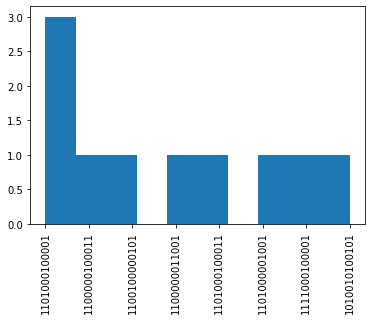

<Figure size 720x720 with 0 Axes>

In [33]:
plt.hist(qubit_results, bins = len(qubit_results))
plt.xticks(rotation='vertical')
plt.figure(figsize=(10,10)) 
plt.show()

In [34]:
result_evaluation(qubit_results[0], test_sg, test_nsg, edge_cost_matrix)

node 0 at time slice 0
				cost: 2.0
node 1 at time slice 1
				cost: 1.0
node 2 at time slice 2
				cost: 2.0
node 4 at time slice 3
				cost: 1.0
node 0 at time slice 5

total cost: 6.0

It seems like no valid solution could be found. This solution disregards at least one constraint.
